<a href="https://colab.research.google.com/github/vishalrk1/pytorch/blob/main/PyTorch_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-12-29 08:04:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 209.85.145.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   131MB/s    in 1.2s    

2021-12-29 08:04:34 (131 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2021-12-29 08:04:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-29 08:04:34 (52.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
unzip_data('10_food_classes_10_percent.zip')

## Writing Custom Dataset function for images

In [5]:
from torch.utils.data import Dataset
from torchvision import transforms

import pathlib
import os
import random
from PIL import Image
from typing import Tuple, Dict, List

In [6]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, str]]:
    """Finds the class folder names in a target directory.

    Args:
        directory ([str]): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, str]]: (list_of_class_names, dict(idx: class_name...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [7]:
class ImageData(Dataset):
  def __init__(self, target_dir, transform):
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.class_name, self.class_to_idx = find_classes(target_dir)

  def __len__(self):
    return len(self.paths)

  def load_image(self, index):
    img_path = self.paths[index]
    return Image.open(img_path)

  def __getitem__(self, index):
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [8]:
from torchvision.transforms.autoaugment import RandAugment
train_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.CenterCrop(224),
    transforms.RandAugment(num_ops=1,magnitude=5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [9]:
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

In [10]:
train_data = ImageData(train_dir, train_transform)
test_data = ImageData(test_dir, test_transform)

In [11]:
len(train_data)

750

In [12]:
# Turning datasets into dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,  batch_size=32, num_workers=8, shuffle=True)
test_dataloader = DataLoader(test_data,  batch_size=32, num_workers=8, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
train_data.class_name

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
img, label = next(iter(train_dataloader))
img.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 224, 224])

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# creating tinyVGG Model

In [34]:
class TinyVGG(nn.Module):
  def __init__(self, input_size, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_size, out_channels=hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2)    
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    # self.conv_block_4 = nn.Sequential(
    #     nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
    #     nn.ReLU(),
    #     nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2)
    # )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*24*24, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    # x = self.conv_block_4(x)
    x = self.classifier(x)
    return x

In [35]:
model_0 = TinyVGG(
    input_size=3,
    hidden_units=32,
    output_shape=len(train_data.class_name)
).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18432, out_features=10, bias=True)
  )
)

In [36]:
!pip install torchinfo

In [37]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  --                        --
├─Sequential: 1-1                        [1, 32, 110, 110]         --
│    └─Conv2d: 2-1                       [1, 32, 222, 222]         896
│    └─ReLU: 2-2                         [1, 32, 222, 222]         --
│    └─Conv2d: 2-3                       [1, 32, 220, 220]         9,248
│    └─ReLU: 2-4                         [1, 32, 220, 220]         --
│    └─MaxPool2d: 2-5                    [1, 32, 110, 110]         --
├─Sequential: 1-2                        [1, 32, 53, 53]           --
│    └─Conv2d: 2-6                       [1, 32, 108, 108]         9,248
│    └─ReLU: 2-7                         [1, 32, 108, 108]         --
│    └─Conv2d: 2-8                       [1, 32, 106, 106]         9,248
│    └─ReLU: 2-9                         [1, 32, 106, 106]         --
│    └─MaxPool2d: 2-10                   [1, 32, 53, 53]           --
├─Seq

In [38]:
# Model training
optimizer = optim.Adam(model_0.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 10

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

for epoch in range(epochs):
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model_0.train()
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model_0.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model_0.eval()
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)

    output = model_0(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(test_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(test_dataloader)

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  print(f'Epoch: {epoch+1}')
  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1
Training Loss: 2.312297 	Training Accuracy: 0.08
Validation Loss: 2.303576 	Validation Accuracy: 0.10
Epoch: 2
Training Loss: 2.304608 	Training Accuracy: 0.10
Validation Loss: 2.302524 	Validation Accuracy: 0.10
Epoch: 3
Training Loss: 2.304482 	Training Accuracy: 0.09
Validation Loss: 2.302280 	Validation Accuracy: 0.14
Epoch: 4
Training Loss: 2.302915 	Training Accuracy: 0.11
Validation Loss: 2.299536 	Validation Accuracy: 0.16
Epoch: 5
Training Loss: 2.291088 	Training Accuracy: 0.14
Validation Loss: 2.273605 	Validation Accuracy: 0.19
Epoch: 6
Training Loss: 2.211621 	Training Accuracy: 0.20
Validation Loss: 2.171418 	Validation Accuracy: 0.19
Epoch: 7
Training Loss: 2.124440 	Training Accuracy: 0.22
Validation Loss: 2.171449 	Validation Accuracy: 0.20
Epoch: 8
Training Loss: 2.077141 	Training Accuracy: 0.26
Validation Loss: 2.163895 	Validation Accuracy: 0.19
Epoch: 9
Training Loss: 2.020088 	Training Accuracy: 0.27
Validation Loss: 2.183024 	Validation Accuracy: 0.20
E

In [51]:
import matplotlib.pyplot as plt

# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  #plt.show()

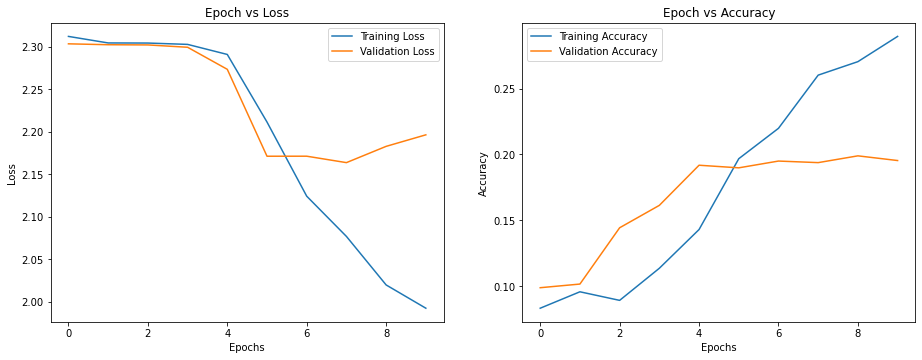

In [52]:
plot_loss_accuracy(results['train_losses'], results['train_acc'], results['valid_losses'], results['valid_acc'])

## Using Pretrained Model

In [40]:
from torchvision import models

In [43]:
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [48]:
class FoodModel(nn.Module):
  def __init__(self, output_shape, is_trainable=False):
    super().__init__()

    self.alexnet = models.alexnet(pretrained=True)
    self.is_trainable = is_trainable

    for param in self.alexnet.parameters():
      param.requires_grad = self.is_trainable
    
    self.alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=output_shape)

  def forward(self, x):
    return self.alexnet(x)

In [49]:
model_1 = FoodModel(
    output_shape=10,
    is_trainable=False,
).to(device)

model_1

FoodModel(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
     

In [53]:
# Model training
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 10

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

for epoch in range(epochs):
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model_1.train()
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model_1.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model_1.eval()
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)

    output = model_1(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(test_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(test_dataloader)

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  print(f'Epoch: {epoch+1}')
  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1
Training Loss: 2.294188 	Training Accuracy: 0.15
Validation Loss: 2.106230 	Validation Accuracy: 0.26
Epoch: 2
Training Loss: 2.020036 	Training Accuracy: 0.29
Validation Loss: 1.915214 	Validation Accuracy: 0.37
Epoch: 3
Training Loss: 1.863146 	Training Accuracy: 0.37
Validation Loss: 1.769798 	Validation Accuracy: 0.44
Epoch: 4
Training Loss: 1.705117 	Training Accuracy: 0.45
Validation Loss: 1.666507 	Validation Accuracy: 0.48
Epoch: 5
Training Loss: 1.631093 	Training Accuracy: 0.47
Validation Loss: 1.601202 	Validation Accuracy: 0.49
Epoch: 6
Training Loss: 1.531158 	Training Accuracy: 0.52
Validation Loss: 1.537005 	Validation Accuracy: 0.52
Epoch: 7
Training Loss: 1.450868 	Training Accuracy: 0.54
Validation Loss: 1.489577 	Validation Accuracy: 0.52
Epoch: 8
Training Loss: 1.407371 	Training Accuracy: 0.54
Validation Loss: 1.451817 	Validation Accuracy: 0.54
Epoch: 9
Training Loss: 1.384113 	Training Accuracy: 0.54
Validation Loss: 1.419493 	Validation Accuracy: 0.55
E

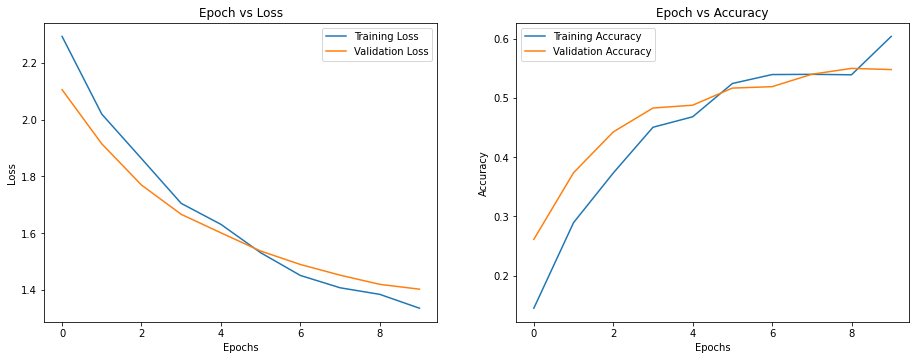

In [54]:
plot_loss_accuracy(results['train_losses'], results['train_acc'], results['valid_losses'], results['valid_acc'])

## Setting training equalt to True

In [55]:
model_2 = FoodModel(
    output_shape=10,
    is_trainable=True,
).to(device)

model_2

FoodModel(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
     

In [56]:
# Model training
optimizer = optim.Adam(model_2.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 10

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

for epoch in range(epochs):
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model_2.train()
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model_2.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model_2.eval()
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)

    output = model_2(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(test_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(test_dataloader)

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  print(f'Epoch: {epoch+1}')
  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1
Training Loss: 2.136233 	Training Accuracy: 0.25
Validation Loss: 1.701730 	Validation Accuracy: 0.41
Epoch: 2
Training Loss: 1.311628 	Training Accuracy: 0.57
Validation Loss: 1.215052 	Validation Accuracy: 0.59
Epoch: 3
Training Loss: 0.914037 	Training Accuracy: 0.71
Validation Loss: 1.206375 	Validation Accuracy: 0.61
Epoch: 4
Training Loss: 0.709231 	Training Accuracy: 0.77
Validation Loss: 1.128282 	Validation Accuracy: 0.64
Epoch: 5
Training Loss: 0.461353 	Training Accuracy: 0.86
Validation Loss: 1.280455 	Validation Accuracy: 0.62
Epoch: 6
Training Loss: 0.327237 	Training Accuracy: 0.89
Validation Loss: 1.226819 	Validation Accuracy: 0.63
Epoch: 7
Training Loss: 0.266125 	Training Accuracy: 0.92
Validation Loss: 1.293111 	Validation Accuracy: 0.65
Epoch: 8
Training Loss: 0.200100 	Training Accuracy: 0.94
Validation Loss: 1.215788 	Validation Accuracy: 0.65
Epoch: 9
Training Loss: 0.148554 	Training Accuracy: 0.96
Validation Loss: 1.383826 	Validation Accuracy: 0.65
E

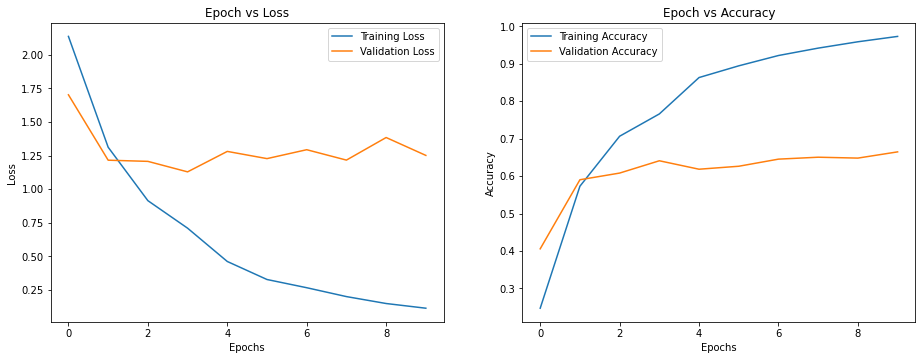

In [57]:
plot_loss_accuracy(results['train_losses'], results['train_acc'], results['valid_losses'], results['valid_acc'])

# Using EfficientNet-B0 Model

In [60]:
class FoodEfficientModel(nn.Module):
  def __init__(self, output_shape, is_trainable=False):
    super().__init__()

    self.model = models.efficientnet_b0(pretrained=True)
    self.is_trainable = is_trainable
    self.output_shape = output_shape

    for param in self.model.parameters():
      param.requires_grad = self.is_trainable

    self.model.classifier[1] = nn.Linear(in_features=1280, out_features=self.output_shape)

  def forward(self, x):
    return self.model(x)

In [61]:
model_3 = FoodEfficientModel(output_shape=10).to(device)
model_3

FoodEfficientModel(
  (model): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

In [62]:
# Model training
optimizer = optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 10

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

for epoch in range(epochs):
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model_3.train()
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model_3.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model_3.eval()
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)

    output = model_3(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(test_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(test_dataloader)

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  print(f'Epoch: {epoch+1}')
  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1
Training Loss: 2.315336 	Training Accuracy: 0.13
Validation Loss: 2.264189 	Validation Accuracy: 0.17
Epoch: 2
Training Loss: 2.255983 	Training Accuracy: 0.17
Validation Loss: 2.207958 	Validation Accuracy: 0.23
Epoch: 3
Training Loss: 2.184519 	Training Accuracy: 0.27
Validation Loss: 2.153381 	Validation Accuracy: 0.31
Epoch: 4
Training Loss: 2.138879 	Training Accuracy: 0.31
Validation Loss: 2.100984 	Validation Accuracy: 0.39
Epoch: 5
Training Loss: 2.093967 	Training Accuracy: 0.34
Validation Loss: 2.053087 	Validation Accuracy: 0.43
Epoch: 6
Training Loss: 2.043460 	Training Accuracy: 0.44
Validation Loss: 2.007947 	Validation Accuracy: 0.49
Epoch: 7
Training Loss: 2.005925 	Training Accuracy: 0.48
Validation Loss: 1.961779 	Validation Accuracy: 0.54
Epoch: 8
Training Loss: 1.954664 	Training Accuracy: 0.51
Validation Loss: 1.915078 	Validation Accuracy: 0.57
Epoch: 9
Training Loss: 1.908078 	Training Accuracy: 0.57
Validation Loss: 1.877782 	Validation Accuracy: 0.60
E

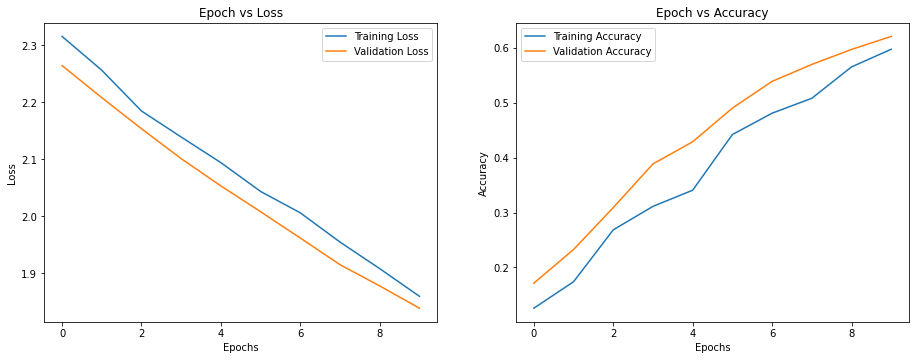

In [63]:
plot_loss_accuracy(results['train_losses'], results['train_acc'], results['valid_losses'], results['valid_acc'])